In [1]:
import numpy as np
import qilisdk
import qutip as qt
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')

import hamiltonian
import dynamics
import plots
import estimator
import VQE

from qilisdk.backends import QutipBackend
from qilisdk.digital import Circuit, M, U1, CNOT, U2, U3, CZ, RX, RZ, H
from qilisdk.functionals.sampling import Sampling, SamplingResult
from qilisdk.functionals.time_evolution import TimeEvolution
from scipy.optimize import minimize

## Create random Hamiltonian with X, Z, and ZZ terms

In [2]:
nqubits = 2

H_test, weights = hamiltonian.create_random_hamiltonian(nqubits, -1.0, 1.0)

psi_0 = dynamics.initialize_down_state(nqubits)

print(H_test.H)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.39902436  0.95692636 -0.59326976  0.        ]
 [ 0.95692636  0.36722248  0.         -0.59326976]
 [-0.59326976  0.         -0.6366611   0.95692636]
 [ 0.         -0.59326976  0.95692636 -0.12958574]]


## Perform a time evolution and extract bitstring probabilities

In [3]:
ti = 0
tf = 2
nsteps = 1000

sim = dynamics.time_evolution(H_test, psi_0, ti, tf, nsteps)

observables = dynamics.calculate_expectation_values(sim, H_test)

print(observables['Sz'][-1])
print(observables['Sx'][-1])

target_state = sim.states[-1]

simulated_probabilities = dynamics.get_bitstring_probabilities(target_state, basis='Z')

print(simulated_probabilities)


[-0.41292044 -0.72926483]
[-0.78566021 -0.02402047]
{'00': 0.015394662730300384, '01': 0.27814511931935876, '10': 0.11997292037137156, '11': 0.5864872975789691}


## Define VQE ansatz, with RX, RZ, and RZZ gates

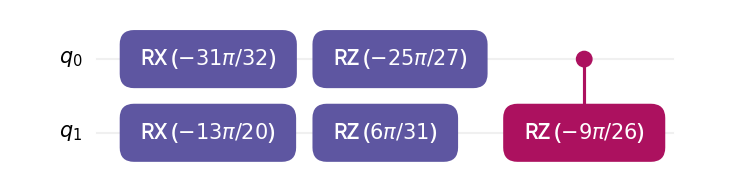

In [4]:
connectivity = VQE.generate_connectivity_list(nqubits, mode = 'ATA')

layers = 1

per_layer = 2*nqubits + len(connectivity)
params_uniform = np.random.uniform(-np.pi, np.pi, size=(layers * per_layer))
params_zero = np.zeros(layers * per_layer)

circuit = VQE.build_ansatz_circuit(params_uniform, nqubits, layers, connectivity)

circuit.draw()


## Example execution

The bitstring probabilities are in principle very different and the fidelity between the states is low. Additionally, we compute the classical fidelity, which means we might be losing information about the true state. This is because the QiliSDK circuit execution only allows for sampling, so we cannot recover the full state from it. Otherwise we would use the quantum fidelity to ensure we find the right state

In [5]:
backend = QutipBackend()
res = backend.execute(functional=Sampling(circuit, nshots = 10000))

experimental_probabilities = res.probabilities

print(simulated_probabilities, "\n")
print(experimental_probabilities, "\n")

print("Fidelity:", estimator.classical_fidelity(simulated_probabilities, experimental_probabilities))

{'00': 0.015394662730300384, '01': 0.27814511931935876, '10': 0.11997292037137156, '11': 0.5864872975789691} 

{'11': 0.7313, '10': 0.2678, '01': 0.0008, '00': 0.0001} 

Fidelity: 0.8503058334390757


## VQE algorithm

We just put the ansatz and cost function through an optimizer. Again, the QiliSDK VQE functions only allow for binary variable cost functions, so for more complex ones, we use scipy directly

In [12]:
layers = 1
per_layer = 2*nqubits + len(connectivity)
params_uniform = np.random.uniform(-np.pi, np.pi, size=(layers * per_layer))
params_zero = np.zeros(layers * per_layer)

connectivity = VQE.generate_connectivity_list(nqubits, mode = 'ATA')

# minimize with scipy 
res = minimize(lambda p: VQE.fidelity_cost(p, nqubits, layers, connectivity, simulated_probabilities, backend=backend),
               params_zero, method='COBYLA',
               options={'maxiter': 200})

print("Optimization finished, success:", res.success, ", loss function:", res.fun)
print("best parameters:", res.x)
print(weights)

Optimization finished, success: True , loss function: 0.0030217039632896014
best parameters: [ 1.97513274 -0.36609902  2.387639    1.45048515 -0.64568608]
[-0.59326976  0.95692636  0.38312342 -0.11881837  0.13471931]


### Test that the optimal parameters give high fidelity

0.996364269979648


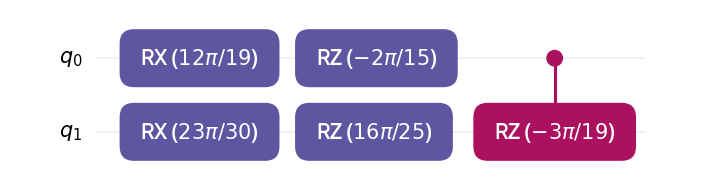

SamplingResult(
  nshots=10000,
  samples={'00': 356, '01': 2596, '10': 884, '11': 6164}
)


In [8]:
circuit = VQE.build_ansatz_circuit(np.array(res.x), nqubits, layers, connectivity)
circuit_simulation = backend.execute(functional=Sampling(circuit, nshots = 10000))
loss = estimator.classical_fidelity(simulated_probabilities, circuit_simulation.probabilities)

print(loss)

circuit.draw()

print(circuit_simulation)